# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys

from MyUtils import clean_folder, read_files
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:

problem = problems[0]
index = 0

# used for n_gram extraction and word indexing, a threshold which prevent words appearing lower than this value to be counted in calculations
tf = 5


infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim()
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels,
                                                                            language[index], tf= tf)

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  63
process_doc, done!
doc count to process:  468
Reading problem 1, done!


# Data Extraction for Neural Net



In [3]:
from MyUtils import extract_n_grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

n = 3
vocabulary = extract_n_grams(train_docs, n, tf)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=False, vocabulary=vocabulary)
n_gram_train_data = vectorizer.fit_transform(train_texts)

n_gram_train_data = n_gram_train_data.astype(float)

for i, v in enumerate(train_texts):
    n_gram_train_data[i] = n_gram_train_data[i] / len(train_texts[i])
n_gram_test_data = vectorizer.transform(test_texts)
n_gram_test_data = n_gram_test_data.astype(float)
for i, v in enumerate(test_texts):
    n_gram_test_data[i] = n_gram_test_data[i] / len(test_texts[i])
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data = max_abs_scaler.fit_transform(n_gram_train_data)
scaled_test_data = max_abs_scaler.transform(n_gram_test_data)
print("Done!")

Done!


In [33]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input, callbacks
from keras.models import Sequential, Model
from keras import optimizers, regularizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]



In [ ]:



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=len(set(train_labels)), random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# print(X_train.shape)

word_input_tensor = Input(shape=(maxlen,) , name='words')


# model = Sequential()
# model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Flatten())
# model.add(layers.Conv1D(32, 3, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.SimpleRNN(embedding_dim, dropout=0.1, recurrent_dropout=0.5, return_sequences= True))
# model.add(layers.SimpleRNN(embedding_dim))
# model.add(Dense(embedding_dim, activation='relu'))
# model.add(layers.Dense(len(set(train_labels)), activation='softmax'))
x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
x = layers.Conv1D(32, 1, activation='relu', padding='same')(x)
# x = layers.MaxPooling1D(2)(x)
y = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 3, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.GlobalMaxPooling1D()(y)

print('y:', y.shape, 'x:', x.shape)
added = layers.add([y, x])
answer = layers.GlobalMaxPooling1D()(added)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(answer)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
conv_1d_s3_model.layers[0].trainable = False
word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s1_model.add(layers.Dropout(0.2))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
conv_1d_s1_model.layers[0].trainable = False
word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_complex_model.add(layers.Dropout(0.2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
conv_1d_complex_model.layers[0].trainable = False
word_output_tensor_2 = conv_1d_complex_model(word_input_tensor)

concatenated = layers.concatenate([word_output_tensor_0, word_output_tensor_1
                                   , word_output_tensor_2
                                  ], axis=-1)
# concatenated = layers.Dense(32, activation='relu')(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_110 (Sequential)     (None, 32)           12202       words[0][0]                      
__________________________________________________________________________________________________
sequential_111 (Sequential)     (None, 32)           12184       words[0][0]                      
__________________________________________________________________________________________________
sequential_112 (Sequential)     (None, 32)           12193       words[0][0]                      
__________________________________________________________________________________________________
concatenat

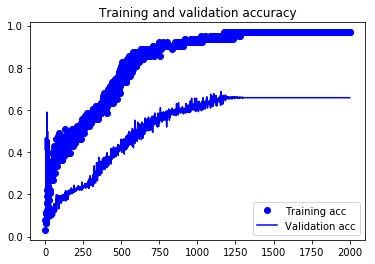

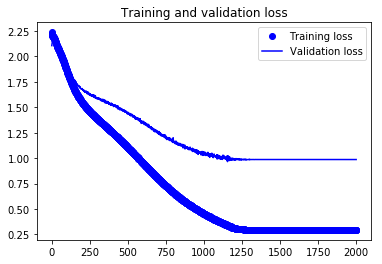

In [27]:
print(acc.max())
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_98 (Sequential)      (None, 32)           12202       words[0][0]                      
__________________________________________________________________________________________________
sequential_99 (Sequential)      (None, 32)           12184       words[0][0]                      
__________________________________________________________________________________________________
sequential_100 (Sequential)     (None, 32)           12193       words[0][0]                      
__________________________________________________________________________________________________
concatenat

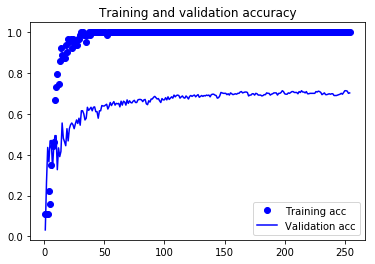

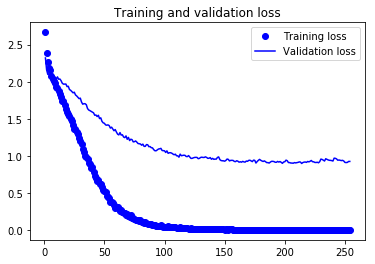

In [53]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s3_model.layers[0].trainable = False
word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.2))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s1_model.layers[0].trainable = False
word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_complex_model.layers[0].trainable = False
word_output_tensor_2 = conv_1d_complex_model(word_input_tensor)

# x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
# x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
# x = layers.Dropout(0.2)(x)
# x = layers.BatchNormalization()(x)
# y = layers.Conv1D(128, 10, activation='relu', padding='same')(x)
# added = layers.add([y, x])
# added = layers.GlobalMaxPooling1D()(added)

concatenated = layers.concatenate([word_output_tensor_0,
                                   word_output_tensor_1,
                                   word_output_tensor_2,
#                                    ,added
                                  ], axis=-1)
# concatenated = layers.Dense(32, activation='relu')(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list,
                    verbose= 2
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [56]:
print(max(val_acc))

0.7136752136752137


In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s3_model.layers[0].trainable = False
word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.2))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s1_model.layers[0].trainable = False
word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_complex_model.layers[0].trainable = False
word_output_tensor_2 = conv_1d_complex_model(word_input_tensor)

# x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
# x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
# x = layers.Dropout(0.2)(x)
# x = layers.BatchNormalization()(x)
# y = layers.Conv1D(128, 10, activation='relu', padding='same')(x)
# added = layers.add([y, x])
# added = layers.GlobalMaxPooling1D()(added)

conv_1d_complex_model_1 = Sequential()
conv_1d_complex_model_1.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model_1.add(layers.Dropout(0.2))
conv_1d_complex_model_1.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model_1.add(layers.BatchNormalization())
conv_1d_complex_model_1.add(layers.MaxPooling1D(2))
conv_1d_complex_model_1.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model_1.add(layers.BatchNormalization())
conv_1d_complex_model_1.add(layers.MaxPooling1D(2))
conv_1d_complex_model_1.add(layers.SeparableConv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model_1.add(layers.BatchNormalization())
conv_1d_complex_model_1.add(layers.GlobalMaxPooling1D())
word_output_tensor_3 = conv_1d_complex_model_1(word_input_tensor)


concatenated = layers.concatenate([word_output_tensor_0,
                                   word_output_tensor_1,
                                   word_output_tensor_2,
                                   word_output_tensor_3,
#                                    ,added
                                  ], axis=-1)
# concatenated = layers.Dense(32, activation='relu')(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list,
                    verbose= 2
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
